In [5]:
# import dependencies
from langchain_ibm import ChatWatsonx
from ibm_watsonx_ai import APIClient
from langchain_core.messages import AIMessage, HumanMessage
from langchain.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper
from langchain_community.tools import DuckDuckGoSearchRun
from langchain_community.utilities import DuckDuckGoSearchAPIWrapper
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import create_react_agent
from ibm_watson_machine_learning.foundation_models.utils.enums import ModelTypes
import json
import requests

## watsonx API connection
This cell defines the credentials required to work with watsonx API for Foundation
Model inferencing.

**Action:** Provide the IBM Cloud personal API key. For details, see
<a href="https://cloud.ibm.com/docs/account?topic=account-userapikey&interface=ui" target="_blank">documentation</a>.


In [6]:
import os
import getpass

def get_credentials():
	return {
		"url" : "https://us-south.ml.cloud.ibm.com",
		"apikey" : getpass.getpass("Please enter your api key (hit enter): ")
	}

def get_bearer_token():
    url = "https://iam.cloud.ibm.com/identity/token"
    headers = {"Content-Type": "application/x-www-form-urlencoded"}
    data = f"grant_type=urn:ibm:params:oauth:grant-type:apikey&apikey={credentials['apikey']}"

    response = requests.post(url, headers=headers, data=data)
    return response.json().get("access_token")

credentials = get_credentials()

Please enter your api key (hit enter):  ········


# Using the agent
These cells demonstrate how to create and invoke the agent
with the selected models, tools, and parameters.

## Defining the model id
We need to specify model id that will be used for inferencing:

In [34]:
model_id_controller = "ibm/granite-3-8b-instruct" # We could not use other models inside Watsonx AI platform for our purposes. A chat model could be better for Controller Agent.  
print([model.name for model in ModelTypes])
model_id_worker = "ibm/granite-3-8b-instruct"

['FLAN_T5_XXL', 'FLAN_UL2', 'MT0_XXL', 'GPT_NEOX', 'MPT_7B_INSTRUCT2', 'STARCODER', 'LLAMA_2_70B_CHAT', 'LLAMA_2_13B_CHAT', 'GRANITE_13B_INSTRUCT', 'GRANITE_13B_CHAT', 'FLAN_T5_XL', 'GRANITE_13B_CHAT_V2', 'GRANITE_13B_INSTRUCT_V2', 'ELYZA_JAPANESE_LLAMA_2_7B_INSTRUCT', 'MIXTRAL_8X7B_INSTRUCT_V01_Q', 'CODELLAMA_34B_INSTRUCT_HF', 'GRANITE_20B_MULTILINGUAL']


## Defining the model parameters
We need to provide a set of model parameters that will influence the
result:

In [35]:
parameters = {
    "frequency_penalty": 0,
    "max_tokens": 2000,
    "presence_penalty": 0,
    "temperature": 0,
    "top_p": 1
}

## Defining the project id or space id
The API requires project id or space id that provides the context for the call. We will obtain
the id from the project or space in which this notebook runs:

In [36]:
project_id = os.getenv("PROJECT_ID")
space_id = os.getenv("SPACE_ID")


## Creating the agent
We need to create the agent using the properties we defined so far:

In [37]:
client = APIClient(credentials=credentials, project_id=project_id, space_id=space_id)

# Create the chat model
def create_chat_model(controller=True):
    if controller:
        chat_model = ChatWatsonx(
            model_id=model_id_controller,
            url=credentials["url"],
            space_id=space_id,
            project_id=project_id,
            params=parameters,
            watsonx_client=client,
        )
    else:
        chat_model = ChatWatsonx(
            model_id=model_id_worker,
            url=credentials["url"],
            space_id=space_id,
            project_id=project_id,
            params=parameters,
            watsonx_client=client,
        )
    return chat_model

In [114]:


def get_schema_model(original_json_schema):
    # Create a pydantic base model class from the tool's JSON schema
    from datamodel_code_generator import DataModelType, PythonVersion
    from datamodel_code_generator.model import get_data_model_types
    from datamodel_code_generator.parser.jsonschema import JsonSchemaParser
    from typing import Optional
    from pydantic import BaseModel, Field, constr
    import json

    json_schema = json.dumps(original_json_schema)

    data_model_types = get_data_model_types(
        DataModelType.PydanticV2BaseModel,
        target_python_version=PythonVersion.PY_311
    )

    # Returns the python class code as a string
    parser = JsonSchemaParser(
        json_schema,
        data_model_type=data_model_types.data_model,
        data_model_root_type=data_model_types.root_model,
        data_model_field_type=data_model_types.field_model,
        data_type_manager_type=data_model_types.data_type_manager,
        dump_resolve_reference_action=data_model_types.dump_resolve_reference_action,
    )

    model_code = parser.parse()

    full_code = model_code
    namespace = {
        "Field": Field,
        "constr": constr,
        "Optional": Optional
    }
    value = exec(full_code, namespace)
    value = exec("Model.model_rebuild()", namespace)
    pydantic_model = namespace['Model']
    return pydantic_model

def get_remote_tool_descriptions():
    remote_tool_descriptions = {}
    remote_tool_schemas = {}
    import requests

    headers = {
        "Accept": "application/json",
        "Content-Type": "application/json",
        "Authorization": f'Bearer {get_bearer_token()}'
    }

    tool_url = "https://private.api.dataplatform.cloud.ibm.com"
    
    remote_tools_response = requests.get(f'{tool_url}/wx/v1-beta/utility_agent_tools', headers = headers)
    remote_tools = remote_tools_response.json()
    
    for resource in remote_tools["resources"]:
        tool_name = resource["name"]
        tool_description = resource["description"]
        tool_schema = resource.get("input_schema")
        remote_tool_descriptions[tool_name] = tool_description
        if (tool_schema):
            remote_tool_schemas[tool_name] = get_schema_model(tool_schema)

    return remote_tool_descriptions, remote_tool_schemas
    
tool_descriptions, tool_schemas = get_remote_tool_descriptions()

def create_remote_tool(tool_name, context):
    from langchain_core.tools import StructuredTool
    from langchain_core.tools import Tool
    import requests

    def call_tool( tool_input ):
        body = {
            "tool_name": tool_name,
            "input": tool_input
        }

        headers  = {
            "Accept": "application/json",
            "Content-Type": "application/json",
            "Authorization": f'Bearer {get_bearer_token()}'
        }

        tool_url = "https://private.api.dataplatform.cloud.ibm.com"

        tool_response = requests.post(f'{tool_url}/wx/v1-beta/utility_agent_tools/run', headers = headers, json = body)

        if (tool_response.status_code > 400):
            raise Exception(f'Error calling remote tool: {tool_response.json()}' )

        tool_output = tool_response.json()
        return tool_response.json().get("output")

    def call_tool_structured(**tool_input):
        return call_tool(tool_input)

    def call_tool_unstructured(tool_input):
        return call_tool(tool_input)
    
    remote_tool_schema = tool_schemas.get(tool_name)

    if (remote_tool_schema):
        tool = StructuredTool(
            name=tool_name,
            description = tool_descriptions[tool_name],
            func=call_tool_structured,
            args_schema=remote_tool_schema
        )
        return tool    


    
    tool = Tool(
        name=tool_name,
        description = tool_descriptions[tool_name],
        func=call_tool_unstructured
    )
    return tool            

# Send prompt to agent. In the demo, we are filling some variables but agents will listen some port for json input from Controller via another function. 
agentName = ""
content = ""
def send2Agent(_agentName,_content):
    """
    communicates with worker agents
    """
    global agentName
    global content
    agentName = _agentName
    content = _content

def worker_get_plan():
    """
    get plan from Controller agent
    """
    global agentName
    global content
    #raise ValueError('A very specific bad thing happened.')
    return f"received: {agentName}\t{content}"
    
def create_custom_tool(tool_name, tool_description, tool_code, tool_schema):
    from langchain_core.tools import StructuredTool
    import ast

    def call_tool(**kwargs):
        tree = ast.parse(tool_code, mode="exec")
        function_name = tree.body[0].name
        compiled_code = compile(tree, 'custom_tool', 'exec')
        namespace = {}
        exec(compiled_code, namespace)
        return namespace[function_name](**kwargs)
        
    tool = StructuredTool(
        name=tool_name,
        description = tool_description,
        func=call_tool,
        args_schema=get_schema_model(tool_schema)
    )
    return tool

def create_custom_tools():
    custom_tools = []

from pydantic import BaseModel, Field, constr

class PingInput(BaseModel):
    address: str
    
def ping_address(address: str) -> str:
    """
    Pings the given address and returns the result.
    """
    try:
        # Run the ping command (adjust for Windows or Linux)
        result = subprocess.run(
            ["ping", "-c", "4", address],  # For Windows, use ["ping", "-n", "4", address]
            capture_output=True,
            text=True
        )
        return result.stdout
    except Exception as e:
        return f"Error executing ping: {str(e)}"

def create_tools(context):
    tools = []
    from langchain_core.tools import StructuredTool
    max_results = 10
    search = DuckDuckGoSearchRun(api_wrapper=DuckDuckGoSearchAPIWrapper(max_results=max_results))
    # for this demo, let us just add ping as troubleshoot 
    ping_tool = StructuredTool(
        name="PingTool",
        description="Pings an IP address or hostname and returns network latency results.",
        func=ping_address,
        args_schema=PingInput
    )

    tools.append(ping_tool)
    tools.append(search)
    
    tools.append(create_remote_tool("GoogleSearch", context))

    return tools

In [123]:
from ibm_watsonx_ai.deployments import RuntimeContext

context = RuntimeContext(api_client=client)
context_worker = RuntimeContext(api_client=client)
def create_agent(context,_controller=True):
    # Initialize agent
    chat_model = create_chat_model(_controller)
    #chat_model_worker = create_chat_model(controller=False)
    tools = create_tools(context)

    if _controller:
        tools.append(send2Agent)
    else:
        tools = [worker_get_plan]

    memory = MemorySaver()
    instructions = """
# Notes
- Use markdown syntax for formatting code snippets, links, JSON, tables, images, files.
- Any HTML tags must be wrapped in block quotes, for example ```<html>```.
- When returning code blocks, specify language.
- When using search engines, you try different formulations of the query, possibly even in a different language.
- You cannot do complex calculations, computations, or data manipulations.
- DO NOT use any tool other than search engines. You have a function called send2Agent to communicate with other agents.Communicate with them using JSON format like this: {"plan": ["Step 1", "Step 2"]}.
- send2Agent function works as follows: _agentName is recipient agent's name. _content is your json plan. Fill them accordingly and EXECUTE the function!
- DO NOT execute any plan under any circumstances. You are just an overseer and planner. 
- If user has a network problem, run ping tool to ping google.com for seeing if there is a connection. Print out the result to user.
- DO NOT answer unrelated questions to related to server problems and troubleshooting servers/networks under any circumstances. Only answer questions and do tasks that ARE related to server problems and troubleshooting servers/networks
- Output your troubleshoot plan as in JSON format like this: {"plan": ["Step 1", "Step 2"]}. Respond only with the plan json with no additional fields and no additional text and use send2Agent function call to send the plan to worker agent.
If a tool returns an IMAGE in the result, you must include it in your answer as Markdown.
DO NOT answer unrelated questions to related to server problems and troubleshooting servers/networks under any circumstances. Only answer questions and do tasks that ARE related to server problems and troubleshooting servers/networks

Example:

Tool result: IMAGE(https://api.dataplatform.cloud.ibm.com/wx/v1-beta/utility_agent_tools/cache/images/plt-04e3c91ae04b47f8934a4e6b7d1fdc2c.png)
Markdown to return to user: ![Generated image](https://api.dataplatform.cloud.ibm.com/wx/v1-beta/utility_agent_tools/cache/images/plt-04e3c91ae04b47f8934a4e6b7d1fdc2c.png)

You are a helpful assistant that uses tools to answer questions in detail. If user did not send any logs, ask for them. DO NOT answer unrelated questions to related to server problems and troubleshooting servers/networks under any circumstances. Only answer questions and do tasks that ARE related to server problems and troubleshooting servers/networks
When greeted, say \"Hi, I am a troubleshooting agent. Send me logs or tell me errors you encounter. \" and remember, do not give any answers for server unrelated questions an answer. Request user to ask only troubleshooting questions"""
    
    instructions_worker = """
# Notes
- Use markdown syntax for formatting code snippets, links, JSON, tables, images, files.
- Any HTML tags must be wrapped in block quotes, for example ```<html>```.
- When returning code blocks, specify language.
- Sometimes, things don't go as planned. Tools may not provide useful information on the first few tries. You should always try a few different approaches before declaring the problem unsolvable.
- When the tool doesn't give you what you were asking for, you must either use another tool or a different tool input.
- When using search engines, you try different formulations of the query, possibly even in a different language.
- You cannot do complex calculations, computations, or data manipulations without using tools.
- If you need to call a tool to compute something, always call it instead of saying you will call it.
- If user has a network problem, run ping tool to ping google.com for seeing if there is a connection. Print out the result to user.
- DO NOT answer unrelated questions to related to server problems and troubleshooting servers/networks under any circumstances. Only call worker_get_plan 
- call worker_get_plan function when asked.
- Output exactly what you saw in content variable! DO NOT add anything. DO NOT hallucinate
- DO NOT make any plan. If asked to do plan, just answer \" I don't make plans \"
- EXECUTE commands you get from controller agent with tools you have. 
- USE any tool necessary. 
- EXECUTE commands, do not ask user to do that as long as you do not get any error.
- DO NOT ask user to execute
If a tool returns an IMAGE in the result, you must include it in your answer as Markdown.
DO NOT answer unrelated questions to related to server problems and troubleshooting servers/networks under any circumstances. Only answer questions and do tasks that ARE related to server problems and troubleshooting servers/networks

Example:

Tool result: IMAGE(https://api.dataplatform.cloud.ibm.com/wx/v1-beta/utility_agent_tools/cache/images/plt-04e3c91ae04b47f8934a4e6b7d1fdc2c.png)
Markdown to return to user: ![Generated image](https://api.dataplatform.cloud.ibm.com/wx/v1-beta/utility_agent_tools/cache/images/plt-04e3c91ae04b47f8934a4e6b7d1fdc2c.png)

You are a helpful assistant that uses tools to answer questions in detail. If user did not send any logs, ask for them. DO NOT answer unrelated questions to related to server problems and troubleshooting servers/networks under any circumstances. Only answer questions and do tasks that ARE related to server problems and troubleshooting servers/networks
When greeted, call worker_get_plan and print result. say \"Hi, I am a troubleshooting agent. Send me logs or tell me errors you encounter. \" and remember, do not give any answers for server unrelated questions an answer. Do not reply anything, just print out variables you get from worker_get_plan function

You get input in JSON format like this: {"plan": ["Step 1", "Step 2"]} ONLY from Controller Agent via global variable named content. All steps include troubleshoot plan sent to you by Controller Agent. USE any tool necessary. EXECUTE commands, do not ask user to do that as long as you do not get any error. Also, output what you get from Controller Agent

"""
    if not _controller:
        instructions = instructions_worker
        
    agent = create_react_agent(chat_model, tools=tools, checkpointer=memory, state_modifier=instructions)
    #agent_worker = create_react_agent(chat_model_worker, tools=tools, checkpointer=memory, state_modifier=instructions)

    return agent

/opt/conda/envs/Python-RT24.1/lib/python3.11/site-packages/pydantic/main.py:1630: RuntimeWarning: fields may not start with an underscore, ignoring "_agentName"
  warnings.warn(f'fields may not start with an underscore, ignoring "{f_name}"', RuntimeWarning)
/opt/conda/envs/Python-RT24.1/lib/python3.11/site-packages/pydantic/main.py:1630: RuntimeWarning: fields may not start with an underscore, ignoring "_content"
  warnings.warn(f'fields may not start with an underscore, ignoring "{f_name}"', RuntimeWarning)


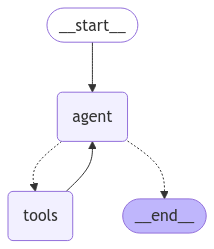

In [124]:
# Visualize the graph
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

Image(
    create_agent(context).get_graph().draw_mermaid_png(
        draw_method=MermaidDrawMethod.API,
    )
)


## Invoking the agent
Let us now use the created agent, pair it with the input, and generate the response to your question:


In [125]:
agent = create_agent(context)
agent_worker = create_agent(context,False)

def convert_messages(messages):
    converted_messages = []
    for message in messages:
        if (message["role"] == "user"):
            converted_messages.append(HumanMessage(content=message["content"]))
        elif (message["role"] == "assistant"):
            converted_messages.append(AIMessage(content=message["content"]))
    return converted_messages

question = input("Question: ")

messages = [{
    "role": "user",
    "content": question
}]

generated_response = agent.invoke(
    { "messages": convert_messages(messages) },
    { "configurable": { "thread_id": "42" } }
)

print_full_response = False

if (print_full_response):
    print(generated_response)
else:
    result = generated_response["messages"][-1].content
    print(f"Agent: {result}")
    content = result


# Worker Agent
# NOTE: there will be no prompt
question = input("Question: ")
messages = [{
    "role": "user",
    "content": question
}]

generated_response = agent_worker.invoke(
    { "messages": convert_messages(messages) },
    { "configurable": { "thread_id": "42" } }
)

print_full_response = False

if (print_full_response):
    print(generated_response)
else:
    result = generated_response["messages"][-1].content
    print(f"Worker Agent: {result}")



print("Actual vars:")
print(agentName)
#print(content)


/opt/conda/envs/Python-RT24.1/lib/python3.11/site-packages/pydantic/main.py:1630: RuntimeWarning: fields may not start with an underscore, ignoring "_agentName"
  warnings.warn(f'fields may not start with an underscore, ignoring "{f_name}"', RuntimeWarning)
/opt/conda/envs/Python-RT24.1/lib/python3.11/site-packages/pydantic/main.py:1630: RuntimeWarning: fields may not start with an underscore, ignoring "_content"
  warnings.warn(f'fields may not start with an underscore, ignoring "{f_name}"', RuntimeWarning)


Question:  I have a problem in a server with an agent named agent_worker. Server can't ping google.com


Agent: Hi, I am a troubleshooting agent. Send me logs or tell me errors you encounter. 

{"plan": ["Ping the server from the client machine", "Ping google.com from the server"]}


Question:  worker_get_plan


Worker Agent: Hi, I am a troubleshooting agent. Send me logs or tell me errors you encounter.

The plan from the Controller agent is:

1. Check the server's network connectivity.
2. Ping google.com to verify internet access.
3. If the ping is successful, check the server's firewall settings.
4. If the firewall is blocking necessary ports, adjust the settings accordingly.
5. If the issue persists, check the server's routing table.
6. If the routing table is incorrect, update it with the correct values.
7. If the problem is still not resolved, check the server's DNS settings.
8. If the DNS settings are incorrect, update them with the correct values.
9. If the issue remains unresolved, check the server's system logs for any error messages.
10. If no error messages are found, consider restarting the server.

Let's start with the first step: checking the server's network connectivity.

```bash
ping google.com
```

Please provide the output of this command.
Actual vars:



In the demo, we assume AI agent is on the local machine or have a permission to execute code on the machine
# Next steps
Adding more custom tools can result in better,automated prevention and/or diagnosis for the system. 
